In [1]:
# %pip install -e ..

In [2]:
from bbva_assignment.sql_connect import config, get_connection, run_sql_command
from pathlib import Path

import pandas as pd

RAW_DATA_PATH = Path(".").absolute().parent / "data" / "raw"

# read connection parameters
params = config(filename=Path(".").absolute().parent / "database.ini")

# Data Exploration
Check which public tables are in the database

In [3]:
conn = get_connection(params)
tables = run_sql_command(
    "SELECT table_name FROM information_schema.tables WHERE table_schema = 'public';",
    conn,
)
tables = [table[0] for table in tables]
print(tables)

['movies', 'ratings', 'tags']


In [4]:
movies_columns = run_sql_command(
    "SELECT column_name FROM information_schema.columns WHERE table_name = 'movies' LIMIT 20;",
    conn,
)
movies_columns = [x[0] for x in movies_columns]
print(movies_columns)

['movie_id', 'title', 'genres']


In [5]:
record = run_sql_command("SELECT * FROM movies FETCH FIRST 10 ROWS ONLY;", conn)
print(record)

[(1, 'Toy Story (1995)', 'Adventure|Animation|Children|Comedy|Fantasy'), (2, 'Jumanji (1995)', 'Adventure|Children|Fantasy'), (3, 'Grumpier Old Men (1995)', 'Comedy|Romance'), (4, 'Waiting to Exhale (1995)', 'Comedy|Drama|Romance'), (5, 'Father of the Bride Part II (1995)', 'Comedy'), (6, 'Heat (1995)', 'Action|Crime|Thriller'), (7, 'Sabrina (1995)', 'Comedy|Romance'), (8, 'Tom and Huck (1995)', 'Adventure|Children'), (9, 'Sudden Death (1995)', 'Action'), (10, 'GoldenEye (1995)', 'Action|Adventure|Thriller')]


In [6]:
movies_df = run_sql_command("SELECT * FROM movies;", conn)
movies_df = pd.DataFrame(movies_df, columns=movies_columns)

# Question 1. How has the distribution of genres of movies evolved over time?

### Data Cleaning

In [7]:
# Extract the year from the title e.g. 1995
col_w_brackets = movies_df.title.str.extract("(\(\d\d\d\d\))", expand=False)
movies_df["year"] = col_w_brackets.str.extract("(\d\d\d\d)", expand=False)
# Count NaN values in year column and remove them
print(f"Number of NaN values in year column: {movies_df.year.isna().sum()}")
movies_df = movies_df[~movies_df.year.isna()]
# Convert year column to int
movies_df["year"] = pd.to_numeric(movies_df.year, errors="coerce").astype(int)
print(f"The count of values that were not numeric are: {movies_df.year.isna().sum()}")


# Remove rows with "(no genres listed)" and count them
no_genre_rows = movies_df["genres"] == "(no genres listed)"
print(f"Removing {sum(no_genre_rows)} rows with NO genres out of {movies_df.shape[0]}")
movies_df = movies_df[~no_genre_rows]

# Split rows with multiple genres (separated by | ) into multiple rows
movies_df["genres"] = movies_df.loc[~no_genre_rows].genres.str.split("|")
movies_df_single_genre = movies_df.explode("genres")

Number of NaN values in year column: 410
The count of values that were not numeric are: 0
Removing 4798 rows with NO genres out of 62013


### Movies released per year

In [8]:
initial_year = movies_df.year.min()
final_year = movies_df.year.max()
initial_year, final_year

(1874, 2019)

In [9]:
movies_per_year = movies_df.groupby("year").size()
max_movies_per_year = movies_per_year.max()
max_movies_per_year_year = movies_per_year.idxmax()
print(
    f"Maximum number of movies released in a year: {max_movies_per_year} in {max_movies_per_year_year}"
)

Maximum number of movies released in a year: 2288 in 2015


### FIG 1. Total number of movies released by year

In [10]:
# Create a line chart of movies per year with bokeh

from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Legend

output_notebook()

years = movies_per_year.index.to_list()
movies = movies_per_year.to_list()
x_range = (years[0], years[-1])
# combine years and movies into a dataset that I can use for the line chart
data = {"years": years, "movies": movies}

p = figure(
    x_range=x_range,
    height=500,
    width=1200,
    title="Number of movies released per year",
    toolbar_location=None,
    tools="hover",
    tooltips="@years: @movies movies",
)

p.add_layout(Legend(), "right")

p.line(
    line_width=2,
    color="blue",
    legend_label="movies",
    x="years",
    y="movies",
    source=data,
)

p.y_range.start = 0
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None

show(p)

Loading BokehJS ...

## Create 2 stacked area chart of genres by year


In [11]:
grouped_df = movies_df_single_genre.groupby(["year", "genres"]).size()

# Pivoting the data and filling missing values with 0
result = grouped_df.unstack(fill_value=0)
# Sort years in ascending order
result = result.sort_index(axis=1)
result.index = result.index.astype(int)

### FIG 2. Absolute change over the years

In [12]:
# Create a stacked bar chart of genres by year with bokeh
from bokeh.palettes import Category20
from bokeh.models import Legend
from bokeh.plotting import figure, output_notebook, show

output_notebook()

years = result.index.to_list()
genres = result.columns.to_list()
x_range = (years[0], years[-1])


# Add a list
data = {"years": years}
for genre in genres:
    data[genre] = result[genre].tolist()

p = figure(
    x_range=x_range,
    height=500,
    width=1200,
    title="Absolute change in movie genres over the years",
    toolbar_location="above",
    tooltips="$name @years: @$name",
)
p.add_layout(Legend(), "right")

p.varea_stack(
    stackers=genres, x="years", color=Category20[19], source=data, legend_label=genres
)

p.y_range.start = 0
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_left"
p.xaxis[0].ticker.desired_num_ticks = 30


# save(p, "stacked.html")
show(p)

Loading BokehJS ...

### FIG 3. Relative change over the years

In [13]:
relative_result = result.div(result.sum(axis=1), axis=0)

In [14]:
# Create a stacked bar chart of genres by year with bokeh

import bokeh
from bokeh.palettes import Category20
from bokeh.plotting import figure, save, output_notebook, show
from bokeh.models import Legend

output_notebook()

years = relative_result.index.to_list()
genres = relative_result.columns.to_list()
x_range = (years[0], years[-1])

# Add a list
data = {"years": years}
for genre in genres:
    data[genre] = relative_result[genre].tolist()

p = figure(
    x_range=x_range,
    height=500,
    width=1200,
    title="Relative change in movie genres over the years",
    toolbar_location="above",
    tooltips="$name @years: @$name",
)

p.add_layout(Legend(), "right")
p.varea_stack(
    stackers=genres, x="years", color=Category20[19], source=data, legend_label=genres
)

p.y_range.start = 0
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_left"
p.xaxis[0].ticker.desired_num_ticks = 30

show(p)

Loading BokehJS ...

### Line Graph of the relative changes over years

In [15]:
from bokeh.palettes import Category20
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Legend

output_notebook()

years = relative_result.index.to_list()
genres = relative_result.columns.to_list()
x_range = (years[0], years[-1])

# Add a list
data = {"years": years}
for genre in genres:
    data[genre] = relative_result[genre].tolist()

p = figure(
    x_range=x_range,
    height=500,
    width=1200,
    title="Relative change in movie genres over the years",
    toolbar_location="above",
    tooltips="$name @years: @$name",
)

p.add_layout(Legend(click_policy="hide"), "right")
for i, genre in enumerate(genres):
    p.line(
        x="years",
        y=genre,
        color=Category20[19][i],
        source=data,
        legend_label=genre,
        line_width=2,
    )

p.y_range.start = 0
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_left"
p.xaxis[0].ticker.desired_num_ticks = 30

show(p)

Loading BokehJS ...

## Summary
In conclusion, Figures 1 and 2 illustrate the exponential growth of the total number of movies from 1874 to 2019, based on the available dataset. The figures show a peak of 2288 in the number of movies released in the year 2015. Notably, there was a significant surge in movie production between 1927 (55 movies) and 1932 (200 movies).

Furthermore, Figure 3 displays the variation in movie genres released each year relative to the total number of movies. For example, we may notice that the genre of `drama` experienced a substantial increase around 1910 compared to other genres. Although the initial movies produced between 1874 and 1888 primarily belonged to the `documentary` genre, the percentage of `documentary` films released remained relatively constant at around 2% from 1900 to 1994. However, starting in 2012, there was a noticeable rise in the percentage, reaching 9% and remaining stable thereafter.

# Question 2. How has the popularity of different genres evolved over time according to user ratings?

TODO: The idea here is that different genres are given different user ratings over time (new generations like more horrors and give higher ratings compared to action or drama?).  How to do this quantitatively without just plotting them?
Should I consider the fact that some users may be younger than others? So maybe the same user gives reviews over 50 years, so its ratings do not change over time, but ratings changes over generations, so maybe I could control this by user and compare users by the time of their first review


In [16]:
record = run_sql_command("SELECT * FROM ratings FETCH FIRST 10 ROWS ONLY;", conn)
print(record)

[(155912, 72011, datetime.datetime(2015, 8, 16, 21, 21, 23, tzinfo=datetime.timezone.utc), 4.0), (155912, 74458, datetime.datetime(2015, 8, 16, 21, 21, 11, tzinfo=datetime.timezone.utc), 5.0), (155912, 79132, datetime.datetime(2015, 8, 16, 21, 17, 14, tzinfo=datetime.timezone.utc), 5.0), (155912, 85414, datetime.datetime(2015, 8, 16, 21, 21, 25, tzinfo=datetime.timezone.utc), 3.0), (155912, 91500, datetime.datetime(2015, 8, 16, 21, 21, 18, tzinfo=datetime.timezone.utc), 4.0), (155912, 92259, datetime.datetime(2015, 8, 16, 21, 19, 24, tzinfo=datetime.timezone.utc), 4.0), (155912, 109487, datetime.datetime(2015, 8, 16, 21, 16, 45, tzinfo=datetime.timezone.utc), 5.0), (155912, 116797, datetime.datetime(2015, 8, 16, 21, 16, 49, tzinfo=datetime.timezone.utc), 3.5), (155913, 1, datetime.datetime(2008, 6, 6, 13, 40, 48, tzinfo=datetime.timezone.utc), 4.0), (155913, 50, datetime.datetime(2008, 6, 6, 5, 29, 53, tzinfo=datetime.timezone.utc), 3.5)]


In [17]:
# Find column names in ratings table
ratings_columns = run_sql_command(
    "SELECT column_name FROM information_schema.columns WHERE table_name = 'ratings';",
    conn,
)
ratings_columns = [column[0] for column in ratings_columns]
print(ratings_columns)

['user_id', 'movie_id', 'timestamp', 'rating']


## Option 1: Compute the average rating by movie
The first option that I implement to analyze the evolution of the popularity of different genres over time assumes that all the reviews of a specific movie are given at the same time, i.e. the year of the movie release. I know this is not true (the review date corresponds to the `timestamp` column in `ratings` table), therefore I also propose another approach (see `Option 2`).

In [18]:
# Sql query to get the average rating for each movie from `ratings` table and then
# join the result with the `movies` table through the `movieId` column
avg_rating_by_movie = run_sql_command(
    """
    SELECT m.movie_id, m.title, unnest(string_to_array(m.genres, '|')) AS genre, r.avg_rating
    FROM (
        SELECT * FROM movies
        WHERE genres != '(no genres listed)'
    ) AS m
    JOIN (
        SELECT movie_id, AVG(rating) AS avg_rating
        FROM ratings
        GROUP BY movie_id
    ) AS r
    ON m.movie_id = r.movie_id
    """,
    conn,
    params,
)
avg_rating_by_movie_df = pd.DataFrame(
    avg_rating_by_movie, columns=["movieId", "title", "genre", "avg_rating"]
)
avg_rating_by_movie_df.head()

,movieId,title,genre,avg_rating
0,1,Toy Story (1995),Adventure,3.893708
1,1,Toy Story (1995),Animation,3.893708
2,1,Toy Story (1995),Children,3.893708
3,1,Toy Story (1995),Comedy,3.893708
4,1,Toy Story (1995),Fantasy,3.893708


### Plot

In [19]:
# Extract the year from the title e.g. 1995
col_w_brackets = avg_rating_by_movie_df.title.str.extract(
    "(\(\d\d\d\d\))", expand=False
)
avg_rating_by_movie_df["year"] = col_w_brackets.str.extract("(\d\d\d\d)", expand=False)
# Count NaN values in year column and remove them
print(
    f"Number of NaN values in year column: {avg_rating_by_movie_df.year.isna().sum()}"
)
avg_rating_by_movie_df = avg_rating_by_movie_df[~avg_rating_by_movie_df.year.isna()]
# Convert year column to int
avg_rating_by_movie_df["year"] = pd.to_numeric(
    avg_rating_by_movie_df.year, errors="coerce"
).astype(int)
print(
    f"The count of values that were not numeric are: {avg_rating_by_movie_df.year.isna().sum()}"
)

avg_rating_by_movie_df.head()

Number of NaN values in year column: 202
The count of values that were not numeric are: 0


,movieId,title,genre,avg_rating,year
0,1,Toy Story (1995),Adventure,3.893708,1995
1,1,Toy Story (1995),Animation,3.893708,1995
2,1,Toy Story (1995),Children,3.893708,1995
3,1,Toy Story (1995),Comedy,3.893708,1995
4,1,Toy Story (1995),Fantasy,3.893708,1995


### NOTE
This approach (and the underlying assumption) leads to some inconsistencies. One of the
most noticeable is that, even though the `ratings` contains the reviews starting from 1995, we have ratings related to movies released in 1937 because the review written in recent years is linked to a very old movie 

In [20]:
avg_rating_by_movie_df[avg_rating_by_movie_df["year"] < 1950]

,movieId,title,genre,avg_rating,year
1224,594,Snow White and the Seven Dwarfs (1937),Animation,3.582302,1937
1225,594,Snow White and the Seven Dwarfs (1937),Children,3.582302,1937
1226,594,Snow White and the Seven Dwarfs (1937),Drama,3.582302,1937
1227,594,Snow White and the Seven Dwarfs (1937),Fantasy,3.582302,1937
1228,594,Snow White and the Seven Dwarfs (1937),Musical,3.582302,1937
...,...,...,...,...,...
102214,208691,Chinatown Squad (1935),Action,4.000000,1935
102215,208691,Chinatown Squad (1935),Crime,4.000000,1935
102236,208733,Valley of the Zombies (1946),Horror,3.000000,1946
102309,208917,Caicedo (with Pole) (1894),Documentary,3.500000,1894


In [21]:
grouped_df = avg_rating_by_movie_df.groupby(["year", "genre"])["avg_rating"].mean()

# Pivoting the data and filling missing values with 0
avg_rating_by_year_genre_df = grouped_df.unstack()
# Sort years in ascending order
avg_rating_by_year_genre_df = avg_rating_by_year_genre_df.sort_index(axis=1)
avg_rating_by_year_genre_df.index = avg_rating_by_year_genre_df.index.astype(int)

In [22]:
avg_rating_by_year_genre_df.head()

genre,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
year,,,,,,,,,,,,,,,,,,,
1874,NaN,NaN,NaN,NaN,NaN,NaN,3.027778,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1880,NaN,NaN,NaN,NaN,NaN,NaN,2.666667,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1888,NaN,NaN,NaN,NaN,NaN,NaN,2.373042,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1890,NaN,NaN,NaN,NaN,2.1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1891,1.444444,NaN,NaN,NaN,NaN,NaN,1.929415,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [23]:
from bokeh.palettes import Category20
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Legend

output_notebook()

years = avg_rating_by_year_genre_df.index.to_list()
genres = avg_rating_by_year_genre_df.columns.to_list()
x_range = (years[0], years[-1])

# Add a list
data = {"years": years}
for genre in genres:
    data[genre] = avg_rating_by_year_genre_df[genre].tolist()

p = figure(
    x_range=x_range,
    height=500,
    width=1200,
    title="Change in ratings of the genres over time",
    toolbar_location="above",
    tooltips="$name @years: @$name",
)

p.add_layout(Legend(click_policy="hide"), "right")
for i, genre in enumerate(genres):
    p.line(
        x="years",
        y=genre,
        color=Category20[19][i],
        source=data,
        legend_label=genre,
        line_width=2,
    )

p.y_range.start = 0
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_left"
p.xaxis[0].ticker.desired_num_ticks = 30

show(p)

Loading BokehJS ...

## Option 2: Compute the average rating by genre and year
The second option uses a SQL query where I consider that the movie reviews are not being written in the same year when the movie was released. So I follow these steps, where I consider each review separately:
1. I extract the year from the `timestamp` column in the `ratings` table
2. I link the review from the `ratings` table to the related movie (`movies` table) and its genres, by joining the 2 tables
3. I explode each row based on its genres (separated by "|" in `genres` column),
    so that I obtain multiple rows for the same review/rating, but with a single genre per row
4. I compute the average rating for each combination of `year` and `genre`



In [24]:
if (RAW_DATA_PATH / "avg_rating_by_genre_year_2.csv").is_file():
    avg_rating_by_genre_year_2_df = pd.read_csv(
        RAW_DATA_PATH / "avg_rating_by_genre_year_2.csv"
    )
else:
    avg_rating_by_genre_year_2 = run_sql_command(
        """
        SELECT z.genre, z.year, AVG(z.rating) AS avg_rating
        FROM (
            SELECT m.movie_id, m.title, unnest(string_to_array(m.genres, '|')) AS genre, r.year, r.rating
            FROM (
                SELECT * FROM movies
                WHERE genres != '(no genres listed)'
            ) AS m
            JOIN (
                SELECT EXTRACT(YEAR FROM timestamp) AS year, rating, movie_id
                FROM ratings
            ) AS r
            ON m.movie_id = r.movie_id
        ) as z
        GROUP BY z.genre, z.year;
        """,
        conn,
        connection_params=params,
    )
    avg_rating_by_genre_year_2_df = pd.DataFrame(
        avg_rating_by_genre_year_2, columns=["genre", "year", "avg_rating"]
    )
    avg_rating_by_genre_year_2_df.to_csv(
        RAW_DATA_PATH / "avg_rating_by_genre_year_2.csv", index=False
    )

In [25]:
avg_rating_by_genre_year_2_df.head()

,genre,year,avg_rating
0,Action,1996,3.436834
1,Action,1997,3.539046
2,Action,1998,3.437515
3,Action,1999,3.451982
4,Action,2000,3.472949


### Check MIN and MAX year in ratings table
I noticed that the minimum year of the table resulting from the SQL query is 1995:

In [26]:
avg_rating_by_genre_year_2_df["year"].min(), avg_rating_by_genre_year_2_df["year"].max()

(1995, 2019)

but the minimum year of the table `movies` is 1874, so I want to check whether something went wrong or if the `ratings` table only contains review of the most recent year:

In [27]:
# SQL query to find the lowest year in ratings table
min_max_year = run_sql_command(
    """
    SELECT MIN(r.year) AS lowest_year, MAX(r.year) AS highest_year
    FROM (
        SELECT EXTRACT(YEAR FROM timestamp) AS year, rating, movie_id
        FROM ratings
    ) as r
    """,
    conn,
    connection_params=params,
)
print(min_max_year)

[(Decimal('1995'), Decimal('2019'))]


Everything is fine! 🎉

### Plot 

In [28]:
# Pivot the table to get the genres as columns
avg_rating_by_genre_year_2_pivot = avg_rating_by_genre_year_2_df.pivot(
    index="year", columns="genre", values="avg_rating"
)
# Filling missing values with 0
avg_rating_by_genre_year_2_pivot = avg_rating_by_genre_year_2_pivot.fillna(0)
# Sort years in ascending order
avg_rating_by_genre_year_2_pivot = avg_rating_by_genre_year_2_pivot.sort_index(axis=1)
avg_rating_by_genre_year_2_pivot.index = avg_rating_by_genre_year_2_pivot.index.astype(
    int
)
avg_rating_by_genre_year_2_pivot.head()

genre,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,IMAX,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
year,,,,,,,,,,,,,,,,,,,
1995,0.000000,0.000000,0.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,0.000000,0.000000,4.000000,0.000000,0.000000
1996,3.436834,3.484267,3.695102,3.505937,3.418091,3.623384,3.861014,3.704054,3.477083,3.601813,3.523734,3.844438,3.649818,3.662336,3.604085,3.421680,3.597001,3.958108,3.549002
1997,3.539046,3.607842,3.657846,3.537464,3.489705,3.723044,3.752944,3.716291,3.557386,3.859687,3.444433,3.859321,3.592470,3.684570,3.621753,3.617656,3.523302,3.957718,3.691440
1998,3.437515,3.513536,3.589627,3.359877,3.435414,3.631531,3.642392,3.674296,3.445903,3.875066,3.142513,3.939785,3.571167,3.638387,3.623731,3.432965,3.450822,3.901081,3.591863
1999,3.451982,3.521106,3.659241,3.478204,3.550452,3.758653,3.959527,3.760375,3.543013,4.141187,3.295656,3.879764,3.662105,3.751629,3.689592,3.444986,3.555416,3.959768,3.576530


In [29]:
from bokeh.palettes import Category20
from bokeh.plotting import figure, output_notebook, show
from bokeh.models import Legend

output_notebook()

years = avg_rating_by_genre_year_2_pivot.index.to_list()
genres = avg_rating_by_genre_year_2_pivot.columns.to_list()
x_range = (years[0], years[-1])

# Add a list
data = {"years": years}
for genre in genres:
    data[genre] = avg_rating_by_genre_year_2_pivot[genre].tolist()

p = figure(
    x_range=x_range,
    height=500,
    width=1200,
    title="Change in ratings of the genres over time",
    toolbar_location="above",
    tooltips="Year: @years",
)

p.add_layout(Legend(click_policy="hide"), "right")
for i, genre in enumerate(genres):
    p.line(
        x="years",
        y=genre,
        color=Category20[19][i],
        source=data,
        legend_label=genre,
        line_width=2,
    )

p.y_range.start = 0
p.xgrid.grid_line_color = None
p.axis.minor_tick_line_color = None
p.outline_line_color = None
p.legend.location = "top_left"
p.xaxis[0].ticker.desired_num_ticks = 30

show(p)

Loading BokehJS ...

## Conclusion
We notice that the average rating of almost every movie genre is in the range [3, 4] for every year that was included in the `ratings` dataset (1995-2019). The genre that received the highest rating was `Film-Noir`, reaching a peak in 1999 and then slowly decreasing. Similarly, the `Documentary` genre decreased over the years.
Interestingly, in 2013 almost every genre received a higher rating compared to the other years.
Moreover `horrors` has slightly increased over years.
`IMAX` and `Children` categories followed a similar path, where their rating decreased from 1999 to 2005-2007 and then increased again reaching a peek in 2013. After that, `Children` category remained stable, while `IMAX` decreased again.


# Question 3. Explore the distribution of tags
Q: Explore the distribution of tags that users submit with their reviews, and how this varies across other covariates.

There are multiple tags for each user review. The key to connect `ratings` and `tags` is the combination `user_id` and `movie_id`

In [30]:
# Find column names in ratings table
tags_columns = run_sql_command(
    "SELECT column_name FROM information_schema.columns WHERE table_name = 'tags';",
    conn,
)
tags_columns = [column[0] for column in tags_columns]
print(tags_columns)

['tag_id', 'user_id', 'movie_id', 'timestamp', 'tag']


In [31]:
import pandas as pd

df_ratings = pd.read_csv(RAW_DATA_PATH / "ratings.csv")

In [32]:
df_ratings.head()

,userId,movieId,rating,timestamp
0,1,296,5.0,1147880044
1,1,306,3.5,1147868817
2,1,307,5.0,1147868828
3,1,665,5.0,1147878820
4,1,899,3.5,1147868510


In [33]:
import pandas as pd

df_tags = pd.read_csv(RAW_DATA_PATH / "tags.csv")

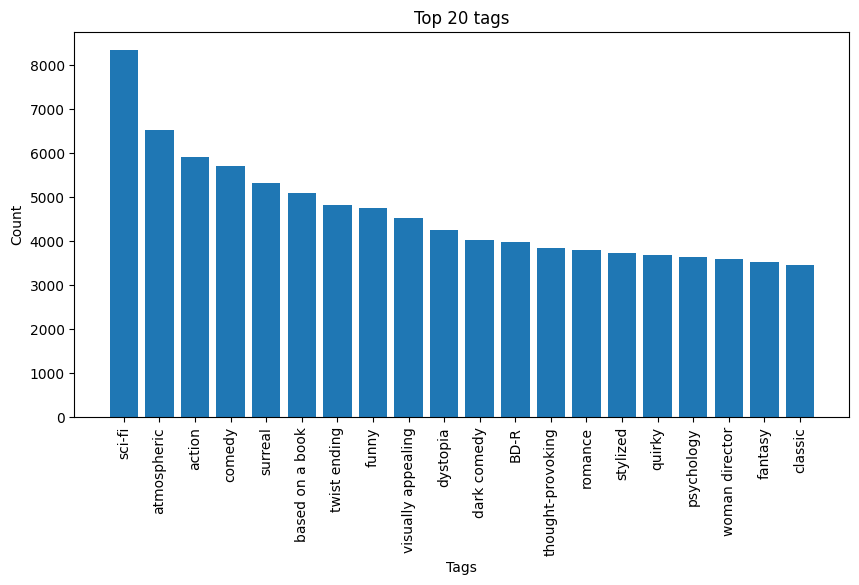

In [34]:
# Create barplot for the top 20 tags
import matplotlib.pyplot as plt

tag_count = df_tags.tag.value_counts()
tag_count_redux = tag_count[tag_count > 100]

plt.figure(figsize=(10, 5))
plt.bar(tag_count_redux.index[:20], tag_count_redux[:20])
plt.xticks(rotation=90)
plt.xlabel("Tags")
plt.ylabel("Count")
plt.title("Top 20 tags")
plt.show()

Combine all tags linked to the same combination of ``(movieId, userId)`` into a single row, so that the combination becomes a unique key and we can merge it with the ratings table

In [35]:
df_multiple_tags = (
    df_tags.groupby(["movieId", "userId"])["tag"]
    .apply(lambda x: "|".join(x.astype(str)))
    .reset_index()
)
df_tags.head()

,userId,movieId,tag,timestamp
0,3,260,classic,1439472355
1,3,260,sci-fi,1439472256
2,4,1732,dark comedy,1573943598
3,4,1732,great dialogue,1573943604
4,4,7569,so bad it's good,1573943455


In [36]:
df_rating_tags = pd.merge(df_multiple_tags, df_ratings, on=["userId", "movieId"])

In [37]:
df_rating_tag_movies = pd.merge(df_rating_tags, movies_df_single_genre, left_on="movieId", right_on="movie_id")
df_rating_tag_movies = df_rating_tag_movies.drop(columns=["movie_id"])
df_rating_tag_movies.head()

,movieId,userId,tag,rating,timestamp,title,genres,year
0,1,791,Owned,4.5,1515175489,Toy Story (1995),Adventure,1995
1,1,791,Owned,4.5,1515175489,Toy Story (1995),Animation,1995
2,1,791,Owned,4.5,1515175489,Toy Story (1995),Children,1995
3,1,791,Owned,4.5,1515175489,Toy Story (1995),Comedy,1995
4,1,791,Owned,4.5,1515175489,Toy Story (1995),Fantasy,1995


### Tree with top tags per movie genre

In [38]:

# explode the tag column to get one tag per row after splitting the tags by "|"
df_rating_single_tag_movies = df_rating_tag_movies.assign(
    tag=df_rating_tag_movies.tag.str.split("|")
).explode("tag")
df_rating_single_tag_movies.head()

,movieId,userId,tag,rating,timestamp,title,genres,year
0,1,791,Owned,4.5,1515175489,Toy Story (1995),Adventure,1995
1,1,791,Owned,4.5,1515175489,Toy Story (1995),Animation,1995
2,1,791,Owned,4.5,1515175489,Toy Story (1995),Children,1995
3,1,791,Owned,4.5,1515175489,Toy Story (1995),Comedy,1995
4,1,791,Owned,4.5,1515175489,Toy Story (1995),Fantasy,1995


In [39]:
# group rows by genre and select the top 3 most frequent tags for each genre
df_rating_tag_movies_top_3 = (
    df_rating_single_tag_movies.groupby(["genres", "tag"])
    .size()
    .reset_index(name="count")
    .groupby("genres")
    .apply(lambda x: x.nlargest(3, "count"))
    .reset_index(drop=True)
)

In [40]:
df_rating_tag_movies_top_3.head()


,genres,tag,count
0,Action,sci-fi,5023
1,Action,action,4898
2,Action,superhero,2549
3,Adventure,sci-fi,3467
4,Adventure,action,2388


In [42]:
# Create a tree based on the genre and tag with anytree
from anytree import Node, RenderTree, AsciiStyle
from anytree.exporter import DotExporter

# Create a root node
root = Node("root")

# Create a node for each genre
genre_nodes = {}
for genre in genres:
    genre_nodes[genre] = Node(genre, parent=root)

# Create a node for each genre-tag combination
for genre in genres:
    for tag in df_rating_tag_movies_top_3[df_rating_tag_movies_top_3.genres == genre].tag:
        Node(tag, parent=genre_nodes[genre])

# Print the tree
print(RenderTree(root, style=AsciiStyle()).by_attr())


root
|-- Action
|   |-- sci-fi
|   |-- action
|   +-- superhero
|-- Adventure
|   |-- sci-fi
|   |-- action
|   +-- fantasy
|-- Animation
|   |-- animation
|   |-- anime
|   +-- Disney
|-- Children
|   |-- animation
|   |-- Disney
|   +-- Pixar
|-- Comedy
|   |-- comedy
|   |-- funny
|   +-- dark comedy
|-- Crime
|   |-- twist ending
|   |-- dark comedy
|   +-- crime
|-- Documentary
|   |-- documentary
|   |-- politics
|   +-- Documentary
|-- Drama
|   |-- atmospheric
|   |-- surreal
|   +-- twist ending
|-- Fantasy
|   |-- fantasy
|   |-- surreal
|   +-- magic
|-- Film-Noir
|   |-- atmospheric
|   |-- film noir
|   +-- stylized
|-- Horror
|   |-- horror
|   |-- zombies
|   +-- atmospheric
|-- IMAX
|   |-- sci-fi
|   |-- visually appealing
|   +-- action
|-- Musical
|   |-- musical
|   |-- Disney
|   +-- animation
|-- Mystery
|   |-- twist ending
|   |-- atmospheric
|   +-- surreal
|-- Romance
|   |-- romance
|   |-- comedy
|   +-- quirky
|-- Sci-Fi
|   |-- sci-fi
|   |-- dystopia
|   